In [1]:
# data prep and model-tuning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectFromModel
from skopt import BayesSearchCV
from sklearn.metrics import (make_scorer, cohen_kappa_score, 
                             precision_recall_curve, confusion_matrix, 
                             plot_precision_recall_curve, precision_score, 
                             recall_score, f1_score)

# types of models we'll fit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import os
import sys
sys.path.append(os.path.abspath('../src/'))

from models.ordinal_classifiers import (LogisticRegressionOrdinalClassifier, 
                                        KNeighborsOrdinalClassifier,
                                        RandomForestOrdinalClassifier,
                                        GradientBoostingOrdinalClassifier)

# for saving things
import pickle
# skopt generates warnings if the same parameter set is sampled again
import warnings

In [2]:
import glob
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix

sns.set_style('darkgrid')
%matplotlib inline

## Our Data

In [3]:
PLOT_DATA = '../data/processed/plot_features.csv'
KEEP_PLOT_COLS = ['uuid', 'lat', 'lon', 'ecoregion3', 'agency', 'distance_to_water_m', 'plot_size_ac', 'meas_yr']
plot_data = pd.read_csv(PLOT_DATA)[KEEP_PLOT_COLS]
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5089 entries, 0 to 5088
Data columns (total 8 columns):
uuid                   5089 non-null object
lat                    5089 non-null float64
lon                    5089 non-null float64
ecoregion3             5089 non-null object
agency                 5089 non-null object
distance_to_water_m    5089 non-null float64
plot_size_ac           5089 non-null float64
meas_yr                5089 non-null int64
dtypes: float64(4), int64(1), object(3)
memory usage: 318.1+ KB


In [4]:
LIDAR_DATA = '../data/processed/lidar_features.csv'
lidar_data = pd.read_csv(LIDAR_DATA)[['uuid', 'elevation']]
lidar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 2 columns):
uuid         5411 non-null object
elevation    5411 non-null float64
dtypes: float64(1), object(1)
memory usage: 84.6+ KB


In [5]:
plot_data = plot_data.merge(lidar_data, left_on=['uuid'], right_on=['uuid'], how='inner').drop_duplicates(subset=['uuid'])
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4272 entries, 0 to 5410
Data columns (total 9 columns):
uuid                   4272 non-null object
lat                    4272 non-null float64
lon                    4272 non-null float64
ecoregion3             4272 non-null object
agency                 4272 non-null object
distance_to_water_m    4272 non-null float64
plot_size_ac           4272 non-null float64
meas_yr                4272 non-null int64
elevation              4272 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 333.8+ KB


In [6]:
INVENTORY = '../data/processed/inventory_features.csv'
inv_data = pd.read_csv(INVENTORY, index_col=['uuid', 'year'])
inv_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49410 entries, (ba510248, 2010) to (c4f7f099, 2025)
Data columns (total 75 columns):
tpa                    49410 non-null int64
ba                     49410 non-null int64
sdi                    49410 non-null int64
ccf                    49410 non-null int64
qmd                    49410 non-null float64
tcuft                  49410 non-null int64
topht                  49410 non-null int64
number_of_strata       49410 non-null int64
total_cover            49410 non-null int64
structure_class        49410 non-null object
canopy_baseheight      49410 non-null int64
canopy_bulkdensity     49410 non-null float64
aboveground_biomass    49410 non-null int64
aboveground_carbon     49410 non-null int64
gs_tpa                 49410 non-null int64
AF                     49410 non-null int64
AS                     49410 non-null int64
BM                     49410 non-null int64
BO                     49410 non-null int64
CH                     4

In [7]:
SATELLITE = '../data/processed/satellite_features.csv'
sat = pd.read_csv(SATELLITE, index_col=['uuid', 'year'])
S2_COLS = [col for col in sat.columns if col.startswith('S2')]
LANDTRENDR_COLS = [col for col in sat.columns if col.startswith('LT')]
sat = sat[S2_COLS + LANDTRENDR_COLS].dropna()
sat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10178 entries, (00027724, 2019) to (fff7e1c3, 2020)
Data columns (total 53 columns):
S2_R_LEAFOFF             10178 non-null float64
S2_G_LEAFOFF             10178 non-null float64
S2_B_LEAFOFF             10178 non-null float64
S2_NIR_LEAFOFF           10178 non-null float64
S2_SWIR1_LEAFOFF         10178 non-null float64
S2_SWIR2_LEAFOFF         10178 non-null float64
S2_RE1_LEAFOFF           10178 non-null float64
S2_RE2_LEAFOFF           10178 non-null float64
S2_RE3_LEAFOFF           10178 non-null float64
S2_RE4_LEAFOFF           10178 non-null float64
S2_R_LEAFON              10178 non-null float64
S2_G_LEAFON              10178 non-null float64
S2_B_LEAFON              10178 non-null float64
S2_NIR_LEAFON            10178 non-null float64
S2_SWIR1_LEAFON          10178 non-null float64
S2_SWIR2_LEAFON          10178 non-null float64
S2_RE1_LEAFON            10178 non-null float64
S2_RE2_LEAFON            10178 non-null float64
S

## Filter out some of the training data
We can exclude some of the training data based on how far separated the inventory data (interpolated using FVS simulations) is from the year the lidar was collected. Similarly, we can screen out training examples that had relatively low density of lidar returns.

In [8]:
sat_and_inv = sat.merge(inv_data, how='inner', left_index=True, right_index=True).reset_index()
sat_and_inv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9385 entries, 0 to 9384
Columns: 130 entries, uuid to LARCH
dtypes: float64(47), int64(81), object(2)
memory usage: 9.3+ MB


In [9]:
df = sat_and_inv.merge(plot_data, how='inner', left_on=['uuid'], right_on=['uuid']).dropna()
print('{:,d} samples'.format(len(df)))
print('Columns:', df.columns.values)

7,952 samples
Columns: ['uuid' 'year' 'S2_R_LEAFOFF' 'S2_G_LEAFOFF' 'S2_B_LEAFOFF'
 'S2_NIR_LEAFOFF' 'S2_SWIR1_LEAFOFF' 'S2_SWIR2_LEAFOFF' 'S2_RE1_LEAFOFF'
 'S2_RE2_LEAFOFF' 'S2_RE3_LEAFOFF' 'S2_RE4_LEAFOFF' 'S2_R_LEAFON'
 'S2_G_LEAFON' 'S2_B_LEAFON' 'S2_NIR_LEAFON' 'S2_SWIR1_LEAFON'
 'S2_SWIR2_LEAFON' 'S2_RE1_LEAFON' 'S2_RE2_LEAFON' 'S2_RE3_LEAFON'
 'S2_RE4_LEAFON' 'S2_NDVI_LEAFON' 'S2_SAVI_LEAFON' 'S2_BRIGHTNESS_LEAFON'
 'S2_GREENNESS_LEAFON' 'S2_WETNESS_LEAFON' 'S2_NDVI_LEAFOFF'
 'S2_SAVI_LEAFOFF' 'S2_BRIGHTNESS_LEAFOFF' 'S2_GREENNESS_LEAFOFF'
 'S2_WETNESS_LEAFOFF' 'S2_dR' 'S2_dG' 'S2_dB' 'S2_dNIR' 'S2_dSWIR1'
 'S2_dSWIR2' 'S2_dRE1' 'S2_dRE2' 'S2_dNDVI' 'S2_dSAVI' 'S2_dBRIGHTNESS'
 'S2_dGREENNESS' 'S2_dWETNESS' 'S2_dRE3' 'S2_dRE4' 'LT_DUR_NBR'
 'LT_DUR_SWIR1' 'LT_MAG_NBR' 'LT_MAG_SWIR1' 'LT_RATE_NBR' 'LT_RATE_SWIR1'
 'LT_YSD_NBR' 'LT_YSD_SWIR1' 'tpa' 'ba' 'sdi' 'ccf' 'qmd' 'tcuft' 'topht'
 'number_of_strata' 'total_cover' 'structure_class' 'canopy_baseheight'
 'canopy_bulkdensity' '

In [10]:
OUTLIERS = '../data/interim/outlier_uuids.csv'
outliers = pd.read_csv(OUTLIERS)
# filter out the height outliers
df = df[~df.uuid.isin(outliers.outlier_uuid)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7952 entries, 0 to 7951
Columns: 138 entries, uuid to elevation
dtypes: float64(52), int64(82), object(4)
memory usage: 8.4+ MB


In [11]:
df['year_diff'] = df['year'] - df['meas_yr']
df = df.loc[np.logical_and(df['year_diff'] < df['LT_YSD_NBR'], df['year_diff'] < df['LT_YSD_SWIR1'])].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7047 entries, 0 to 7046
Columns: 139 entries, uuid to year_diff
dtypes: float64(52), int64(83), object(4)
memory usage: 7.5+ MB


In [12]:
df = df.loc[(df.topht > 0)&(df.total_cover >= 10)&(df.qmd > 0)]
df.loc[df.qmd > 50, 'qmd'] = 50
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6626 entries, 0 to 7046
Columns: 139 entries, uuid to year_diff
dtypes: float64(52), int64(83), object(4)
memory usage: 7.1+ MB


In [13]:
CLIM_DATA = '../data/processed/climate_features_annual.csv'
climate = pd.read_csv(CLIM_DATA)
CLIM_COLS = [col for col in climate.columns if col not in ['uuid', 'year']]
# climate data runs from 2000-2017, let's just take an average of each attribute across this timeframe
climate = climate.groupby(['uuid']).mean().drop(['year'], axis=1).reset_index()
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5089 entries, 0 to 5088
Data columns (total 23 columns):
uuid     5089 non-null object
MAT      5089 non-null float64
MWMT     5089 non-null float64
MCMT     5089 non-null float64
TD       5089 non-null float64
MAP      5089 non-null float64
MSP      5089 non-null float64
AHM      5089 non-null float64
SHM      5089 non-null float64
DD_0     5089 non-null float64
DD5      5089 non-null float64
DD_18    5089 non-null float64
DD18     5089 non-null float64
NFFD     5089 non-null float64
bFFP     5089 non-null float64
eFFP     5089 non-null float64
FFP      5089 non-null float64
PAS      5089 non-null float64
EMT      5089 non-null float64
EXT      5089 non-null float64
Eref     5089 non-null float64
CMD      5089 non-null float64
RH       5089 non-null float64
dtypes: float64(22), object(1)
memory usage: 914.5+ KB


In [14]:
df = df.merge(climate, on=['uuid'], how='left')

## Selecting initial features and targets
This is the first step in determining what features we want to use, and what we want to predict. Later, we can still apply some procedures to choose a subset of these features to make simpler models.

Now we can apply this threshold to all the species-group-level basal areas for the plots to create a binary presence/absence classification for each species group on each plot. 

In [15]:
BA_COLS = ['TRUE_FIR', 'OTHER_HARDWOOD', 'MAPLE', 'OAK', 'DOUGLAS_FIR', 
           'SPRUCE', 'CEDAR', 'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 
           'LODGEPOLE_PINE', 'HEMLOCK', 'RED_ALDER', 'TANOAK', 'JUNIPER',
           'LARCH']

pres_cols = [x + '_pres' for x in BA_COLS]
spp_presence = (df[BA_COLS].values.reshape(-1,1) > 0).reshape(df[BA_COLS].shape)*1
spp_presence = pd.DataFrame(data=spp_presence, columns=pres_cols)

We'll use the following classification of abundance for each species:

| label | description | basal area |  
| :--: | :--: | :--: |
| 0 | absent | 0% |  
| 1 | present | (0-33%] |  
| 2 | abundant | (33-66%] |
| 3 | dominant | (66-100%] |

In [16]:
ba_prop = df[BA_COLS].divide(df[BA_COLS].sum(axis=1) + 1e-9, axis=0)
prop_cols = [x + '_prop' for x in BA_COLS]
ba_prop.columns = prop_cols

SW_SPP = ['TRUE_FIR', 'DOUGLAS_FIR', 'SPRUCE', 'CEDAR', 
          'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 'LODGEPOLE_PINE', 
          'HEMLOCK', 'JUNIPER', 'LARCH']
SW_PROP_COLS = [spp+'_prop' for spp in SW_SPP]
HW_SPP = ['OTHER_HARDWOOD','MAPLE', 'OAK', 'RED_ALDER', 'TANOAK']
HW_PROP_COLS = [spp+'_prop' for spp in HW_SPP]

ba_prop['ALL_HARDWOOD_prop'] = ba_prop[HW_PROP_COLS].sum(axis=1)
ba_prop['ALL_SOFTWOOD_prop'] = ba_prop[SW_PROP_COLS].sum(axis=1)
# prop_cols.extend(['ALL_HARDWOOD_prop', 'ALL_SOFTWOOD_prop'])

abund_cols = [x + '_abund' for x in BA_COLS]
# abund_cols.extend(['ALL_HARDWOOD_abund', 'ALL_SOFTWOOD_abund'])

spp_abund = pd.DataFrame(data=np.digitize(ba_prop[prop_cols].values, [0,1/3,2/3], right=True), 
                         index=ba_prop.index,
                         columns=abund_cols)

In [17]:
spp_abund['HARDWOOD_SOFTWOOD_abund'] = np.nan

# hardwood dominance, no softwood presence
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] >= 0.66) & 
              (ba_prop['ALL_SOFTWOOD_prop'] < 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = -2

# hardwood dominance, softwood presence
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] >= 0.66) & 
              (ba_prop['ALL_SOFTWOOD_prop'] >= 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = -1

# no basal area recorded, nonstocked
spp_abund.loc[np.isclose(ba_prop['ALL_HARDWOOD_prop'],0) & 
              np.isclose(ba_prop['ALL_SOFTWOOD_prop'],0),
              'HARDWOOD_SOFTWOOD_abund'] = -9998

# softwood dominance, hardwood presence
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] >= 0.66) & 
              (ba_prop['ALL_HARDWOOD_prop'] >= 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = 1

# softwood dominance, no hardwood presence
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] >= 0.66) & 
              (ba_prop['ALL_HARDWOOD_prop'] < 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = 2

# softwood and hardwood equal at 40-50%
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] >= 0.33)&
              (ba_prop['ALL_HARDWOOD_prop'] >= 0.33)& 
              (ba_prop['ALL_SOFTWOOD_prop'] >= 0),
              'HARDWOOD_SOFTWOOD_abund'] = 0

spp_abund['HARDWOOD_SOFTWOOD_abund'] = spp_abund['HARDWOOD_SOFTWOOD_abund'].astype(int) + 2

In [18]:
spp_df = pd.concat([ba_prop, spp_abund], axis=1)
spp_df.head()

,TRUE_FIR_prop,OTHER_HARDWOOD_prop,MAPLE_prop,OAK_prop,DOUGLAS_FIR_prop,SPRUCE_prop,CEDAR_prop,PONDEROSA_PINE_prop,OTHER_SOFTWOOD_prop,LODGEPOLE_PINE_prop,...,CEDAR_abund,PONDEROSA_PINE_abund,OTHER_SOFTWOOD_abund,LODGEPOLE_PINE_abund,HEMLOCK_abund,RED_ALDER_abund,TANOAK_abund,JUNIPER_abund,LARCH_abund,HARDWOOD_SOFTWOOD_abund
0,0.416667,0.0,0.0,0.0,0.342593,0.0,0.0,0.027778,0.0,0.203704,...,0,1,0,1,0,0,0,0,1,4
1,0.419048,0.0,0.0,0.0,0.342857,0.0,0.0,0.028571,0.0,0.200000,...,0,1,0,1,0,0,0,0,1,4
2,0.037500,0.0,0.0,0.0,0.962500,0.0,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,4
3,0.037657,0.0,0.0,0.0,0.962343,0.0,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,4
4,0.535714,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0,0,0,0,2,0,0,0,0,4


In [19]:
spp_df.columns

Index(['TRUE_FIR_prop', 'OTHER_HARDWOOD_prop', 'MAPLE_prop', 'OAK_prop',
       'DOUGLAS_FIR_prop', 'SPRUCE_prop', 'CEDAR_prop', 'PONDEROSA_PINE_prop',
       'OTHER_SOFTWOOD_prop', 'LODGEPOLE_PINE_prop', 'HEMLOCK_prop',
       'RED_ALDER_prop', 'TANOAK_prop', 'JUNIPER_prop', 'LARCH_prop',
       'ALL_HARDWOOD_prop', 'ALL_SOFTWOOD_prop', 'TRUE_FIR_abund',
       'OTHER_HARDWOOD_abund', 'MAPLE_abund', 'OAK_abund', 'DOUGLAS_FIR_abund',
       'SPRUCE_abund', 'CEDAR_abund', 'PONDEROSA_PINE_abund',
       'OTHER_SOFTWOOD_abund', 'LODGEPOLE_PINE_abund', 'HEMLOCK_abund',
       'RED_ALDER_abund', 'TANOAK_abund', 'JUNIPER_abund', 'LARCH_abund',
       'HARDWOOD_SOFTWOOD_abund'],
      dtype='object')

In [20]:
# merge these presence and abundance classes into the dataframe
df = pd.concat([df, spp_df], axis=1)
df.head()

,uuid,year,S2_R_LEAFOFF,S2_G_LEAFOFF,S2_B_LEAFOFF,S2_NIR_LEAFOFF,S2_SWIR1_LEAFOFF,S2_SWIR2_LEAFOFF,S2_RE1_LEAFOFF,S2_RE2_LEAFOFF,...,CEDAR_abund,PONDEROSA_PINE_abund,OTHER_SOFTWOOD_abund,LODGEPOLE_PINE_abund,HEMLOCK_abund,RED_ALDER_abund,TANOAK_abund,JUNIPER_abund,LARCH_abund,HARDWOOD_SOFTWOOD_abund
0,91cde5f3,2020,404.318245,435.381561,253.929603,1804.279228,499.102194,305.519578,786.233269,1564.558734,...,0,1,0,1,0,0,0,0,1,4
1,91cde5f3,2019,796.302694,823.758123,656.771452,2290.226604,382.204665,289.251041,1270.185504,2111.983060,...,0,1,0,1,0,0,0,0,1,4
2,35d5e3a3,2020,334.071332,470.512908,370.767663,2164.548234,563.031929,297.568614,580.915082,1650.450408,...,0,0,0,0,0,0,0,0,0,4
3,35d5e3a3,2019,1649.710598,1765.105299,1315.627038,2618.654212,1081.296875,791.733696,2041.633492,2489.745584,...,0,0,0,0,0,0,0,0,0,4
4,2c6aad1d,2019,178.441770,258.435264,225.049772,2814.152895,839.547820,384.838321,651.762199,2317.617762,...,0,0,0,0,2,0,0,0,0,4


In [21]:
abund_cols

['TRUE_FIR_abund',
 'OTHER_HARDWOOD_abund',
 'MAPLE_abund',
 'OAK_abund',
 'DOUGLAS_FIR_abund',
 'SPRUCE_abund',
 'CEDAR_abund',
 'PONDEROSA_PINE_abund',
 'OTHER_SOFTWOOD_abund',
 'LODGEPOLE_PINE_abund',
 'HEMLOCK_abund',
 'RED_ALDER_abund',
 'TANOAK_abund',
 'JUNIPER_abund',
 'LARCH_abund']

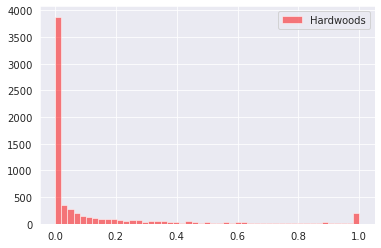

In [22]:
fig, ax = plt.subplots()
ax.hist(ba_prop['ALL_HARDWOOD_prop'], bins=np.linspace(0,1,50), color='red', alpha=0.5, label='Hardwoods')
# ax.hist(ba_prop['ALL_SOFTWOOD_prop'], bins=np.linspace(0,1,20), color='blue', alpha=0.5, label='Softwoods')
ax.legend()
plt.show()

In [23]:
X_COLS = ['total_cover', 'qmd', 'topht', 'elevation'] + S2_COLS + LANDTRENDR_COLS + CLIM_COLS

In [24]:
df = df.dropna(subset=X_COLS+abund_cols).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6626 entries, 0 to 6625
Columns: 194 entries, uuid to HARDWOOD_SOFTWOOD_abund
dtypes: float64(91), int64(99), object(4)
memory usage: 9.8+ MB


## Split the data into training and testing sets
Since some plot_ids have multiple observations, we want all observations for each plot_id to fall entirely in train_set or entirely the training or testing sets because these samples are definitely not independent.

In [25]:
RANDOM_STATE = 12071983
# create training and testing sets for each species group
train_sets = []
test_sets = []

# make sure each plot (uuid) only goes into either train or testing set
uuids = pd.unique(df['uuid'].values)
np.random.seed(RANDOM_STATE)
train0_test1 = np.random.choice((0,1), uuids.shape, p=(0.8,0.2))
train_test_assign = pd.DataFrame(np.dstack((uuids, train0_test1))[0], columns=['uuid', 'train0_test1'])
df_assigned = df.merge(train_test_assign, on='uuid')
    
train = df_assigned.loc[df_assigned['train0_test1'] == 0]
test = df_assigned.loc[df_assigned['train0_test1'] == 1]

## Standardize features
Scale all predictive features to have 0 mean and unit variance (subtracting mean, dividing by standard deviation).

In [26]:
os.makedirs('../models/composition_ordinal_satellite/sklearn_tuned', exist_ok=True)

In [27]:
X_train, X_test = train[X_COLS].copy(), test[X_COLS].copy()
x_scaler = StandardScaler()
x_scaler.fit(df[X_COLS])

X_train[X_COLS], X_test[X_COLS] = x_scaler.transform(X_train), x_scaler.transform(X_test)

Y_train, Y_test = train[spp_df.columns], test[spp_df.columns]

pickle.dump(x_scaler, 
            open('../models/composition_hurdle_satellite/sklearn_tuned/x_scaler.pkl', 'wb'))

# Quick Look at Data
Be aware that the data are heavily skewed towards particularly widespread species like Douglas-fir, western hemlock, and red alder. There are far fewer examples, particularly of plots with other species where those species are abundant.

In [28]:
counts = df[abund_cols].apply(np.bincount, axis=0, minlength=4)
counts.columns = [col.split('_abund')[0] for col in counts.columns]
counts = counts.rename({0: 'absent', 1:'present', 2:'abundant', 3:'dominant'}, axis=0)
counts.T.sort_values(by='absent')\
.style.format('{:,d}')

,absent,present,abundant,dominant
DOUGLAS_FIR,"1,617","1,039","1,199","2,771"
HEMLOCK,"3,720","1,739",680,487
RED_ALDER,"5,071","1,090",243,222
TRUE_FIR,"5,075",965,329,257
CEDAR,"5,138","1,173",235,80
OTHER_HARDWOOD,"5,162","1,212",146,106
PONDEROSA_PINE,"5,822",310,187,307
MAPLE,"5,966",593,45,22
SPRUCE,"6,214",290,77,45
OTHER_SOFTWOOD,"6,286",323,7,10


In [29]:
counts = test[abund_cols].apply(np.bincount, axis=0, minlength=4)
counts.columns = [col.split('_abund')[0] for col in counts.columns]
counts = counts.rename({0: 'absent', 1:'present', 2:'abundant', 3:'dominant'}, axis=0)
counts.T.sort_values(by='absent')\
.style.format('{:,d}')

,absent,present,abundant,dominant
DOUGLAS_FIR,347,205,234,518
HEMLOCK,696,358,140,110
TRUE_FIR,978,199,77,50
RED_ALDER,"1,000",217,45,42
CEDAR,"1,010",229,50,15
OTHER_HARDWOOD,"1,061",183,34,26
PONDEROSA_PINE,"1,139",73,27,65
MAPLE,"1,183",105,12,4
SPRUCE,"1,216",58,19,11
OTHER_SOFTWOOD,"1,238",66,0,0


In [30]:
df.groupby('HARDWOOD_SOFTWOOD_abund')['uuid'].count()

HARDWOOD_SOFTWOOD_abund
0     231
1     200
2     474
3    1355
4    4366
Name: uuid, dtype: int64

## Fit some models

In [31]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer, Space
from skopt.callbacks import CheckpointSaver
from skopt import dump, load

In [32]:
MODEL_SEARCH_SPACES = {
    'rf': {
        'n_estimators': Integer(50, 5000, prior='uniform'),
        'max_depth': Integer(5, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
    },
    'rf_reg': {
        'n_estimators': Integer(50, 5000, prior='uniform'),
        'max_depth': Integer(5, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
    },
    'bal_rf': { 
        'n_estimators': Integer(50, 5000, prior='uniform'),
        'max_depth': Integer(5, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
    },
    'log': {
        'penalty': Categorical(['l1', 'l2', 'elasticnet', 'none']),
        'multi_class': Categorical(['ovr', 'multinomial']),
        'C': Real(1e-4, 1e4, prior='uniform'),
        'l1_ratio': Real(0, 1, prior='uniform'),
    },
    'svc':{
        'C': Real(1e-3, 1e2, prior='uniform'),
        'gamma': Real(1e-3, 1, prior='uniform'),
    },
    'kde':{
        'bandwidth': Real(1e-3, 1, prior='uniform'),
        'kernel': Categorical(['gaussian', 'tophat', 'epanechnikov', 
                               'exponential', 'linear', 'cosine']),
    },
    'knn': {
        'n_neighbors': Integer(1, 2, prior='uniform'),
        'weights': Categorical(['uniform', 'distance']), 
        'p': Integer(1, 100, prior='log-uniform')
    },
}

MODEL_TYPES = {
    'rf': RandomForestOrdinalClassifier(random_state=RANDOM_STATE,
                                 class_weight='balanced',
                                 n_jobs=-1),
    'rf_reg': RandomForestRegressor(random_state=RANDOM_STATE,
                                    n_jobs=-1),
    'log': LogisticRegressionOrdinalClassifier(random_state=RANDOM_STATE,
                              class_weight='balanced',
                              solver='saga',
                              n_jobs=-1),
#     'svc': SVC(random_state=RANDOM_STATE,
#                class_weight='balanced',
#                kernel='rbf'),
#     'kde': KDEClassifier(),
    'knn': KNeighborsOrdinalClassifier(n_jobs=-1)
}

In [55]:
def fuzzy_accuracy(obs, pred, fuzzy_tol=0):
    diff = abs(pred - obs)
    return (diff <= fuzzy_tol).sum() / len(diff)

In [33]:
groupkfold = GroupKFold(n_splits=3)
uuid_groups = df.reindex(X_train.index)['uuid']
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score, average_precision_score

# scorer = make_scorer(geometric_mean_score) 
# scorer = make_scorer(cohen_kappa_score, weights='linear')

def cohen_kappa_adjust(y_true, y_pred, labels=None, weights=None, sample_weight=None):
    if y_pred.dtype == 'float' and y_pred.max() <= 1.0: # regression model trained on proportions
        y_true = np.digitize(y_true, [0,1/3,2/3], right=True)
        y_pred = np.digitize(y_pred, [0,1/3,2/3], right=True)
    
    elif y_pred.dtype == 'float' and y_pred.max() > 1.0: # regression model trained on abundance integers
        y_true = y_true.round().astype(int)
        y_pred = y_pred.round().astype(int)
        
    return cohen_kappa_score(y_true, y_pred, labels=labels, weights=weights, sample_weight=sample_weight)



def tune_classifier(sp_name, model_type, samples_per_param=100, n_jobs=1, n_points=1, labels=None, weights='linear'):
    if model_type[-4:] == '_reg':
        y_train = Y_train[sp_name+'_prop']
    else:
        y_train = Y_train[sp_name+'_abund']
    
    model = MODEL_TYPES[model_type]
    search_space = {'model__{}'.format(key): value for (key, value) in MODEL_SEARCH_SPACES[model_type].items()}
    
    pipeline = Pipeline([# ('resampler', ADASYN(random_state=RANDOM_STATE, n_jobs=-1)),
                         ('model', model)])
    
    scorer = make_scorer(cohen_kappa_adjust, labels=labels, weights=weights)
    
    opt = BayesSearchCV(
        pipeline,
        search_space,
        n_iter=samples_per_param,
        random_state=RANDOM_STATE,
        cv=groupkfold,
        scoring=scorer,
        verbose=0,
        n_jobs=n_jobs,
        n_points=n_points,
    )
    
    # callback handler
    best_score = 0
    
    def on_step(optim_result):
        i = np.max(opt.cv_results_['rank_test_score'])
        if i % 10 == 1:
            print('\n@ sample iteration {}'.format(i), flush=True)
            
        score = opt.best_score_
        if min(opt.cv_results_['rank_test_score'][-n_points:]) == 1:
            print('','{:0.3f}'.format(score), end=' ', flush=True)
        else:
            print('.', end='', flush=True)
    
    SAVE_DIR = '../models/composition_ordinal_satellite/sklearn_tuned/'
    check_pkl = '{}_{}_tuned_checkpoints.pkl'.format(sp_name, model_type)
    check_path = os.path.join(SAVE_DIR, check_pkl)
    checkpoint_saver = CheckpointSaver(check_path)

    print('Running {:,d} rounds of cross-validation.'.format(opt.total_iterations))
    print('Sampling {} parameters {} times each.'.format(len(search_space), samples_per_param))
    print('Displaying best cross-validation scores... ')
    
    with warnings.catch_warnings():  # don't issue warnings when we test the same parameter values
        warnings.filterwarnings("ignore", 
                                category=UserWarning) 
        
        # executes bayesian optimization
        _ = opt.fit(X_train, y_train, 
                    groups=uuid_groups, 
                    callback=[on_step, checkpoint_saver])
    
    opt_pkl = '{}_{}_tuned.pkl'.format(sp_name, model_type)
    opt_path = os.path.join(SAVE_DIR, opt_pkl)
    dump(opt, opt_path)
    print('Done. \nModel saved at {}\n'.format(opt_path))
    
    return opt

In [34]:
def print_classification_report(sp_name, model, 
                                target_names=['absent', 'present', 'abundant', 'dominant']):
    print(classification_report_imbalanced(
        Y_test[sp_name+'_abund'],
        model.predict(X_test),
        target_names=target_names))

To help interpret classification reports:
* `tp` is the number of true positives
* `fp` is the number of false positives, 
* `tn` is the number of true negatives 
* `fn` is the number of false negatives

**precision** is the ratio `tp / (tp + fp)`, or **the ability of the classifier not to label as positive a sample that is negative.** 

**recall** is the ratio `tp / (tp + fn)`, or **the ability of the classifier to find all the positive samples.**

**specificity** is the ratio `tn / (tn + fp)`, or **the ability of the classifier to find all the negative samples.**

In [35]:
def display_confusion(sp_name, model, 
                      labels=[0, 1, 2, 3],
                      display_labels=['Absent', 'Present', 'Abundant', 'Dominant']):
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    plot_confusion_matrix(model, 
                          X_test, 
                          Y_test[sp_name+'_abund'],
                          labels=labels,
                          normalize='true',
                          display_labels=display_labels,
                          include_values=True,
                          values_format='.1%',
                          cmap='Greens', ax=axs[0])
    
    plot_confusion_matrix(model, 
                          X_test, 
                          Y_test[sp_name+'_abund'],
                          labels=labels,
                          display_labels=display_labels,
                          include_values=True,
                          values_format=',d',
                          cmap='Greens', ax=axs[1])
    axs[0].grid(False)
    axs[1].grid(False)
    plt.show();

In [36]:
def plot_rf_feature_importances(model):
    best_model = model.best_estimator_.steps[0][-1]
    importances = best_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
                 axis=0)
    indices = np.argsort(importances)#[::-1]

    # Plot the feature importances of the forest
    plt.figure(figsize=(3,10))
    plt.title("Feature importances")
    plt.barh(range(X_train.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
    plt.ylim([-1, X_train.shape[1]])
    plt.show();

In [37]:
spp_models = {spp:{} for spp in BA_COLS + ['HARDWOOD_SOFTWOOD']}

In [38]:
# max_depths = np.linspace(1, 200, 20)
# train_results = []
# val_results = []
# test_results = []
# for max_depth in max_depths:
    
#     rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators=100, 
#                                 max_features='sqrt', class_weight='balanced')
#     for train_index, val_index in groupkfold.split(X_train, groups=uuid_groups):
#         train_set = X_train.iloc[train_index]
#         val_set = X_train.iloc[val_index]
#         rf.fit(train_set, Y_train['HARDWOOD_SOFTWOOD_abund'].iloc[train_index])
#         train_pred = rf.predict(train_set)
#         val_pred = rf.predict(val_set)
#         train_score = cohen_kappa_score(
#             Y_train['HARDWOOD_SOFTWOOD_abund'].iloc[train_index], 
#             train_pred, weights='linear')
#         train_results.append(train_score)
        
#         val_score = cohen_kappa_score(
#             Y_train['HARDWOOD_SOFTWOOD_abund'].iloc[val_index], 
#             val_pred, weights='linear')
#         val_results.append(val_score)

# #     rf.fit(X_train, Y_train['HARDWOOD_SOFTWOOD_abund'])
# #     train_pred = rf.predict(X_train)
# #     train_score = cohen_kappa_score(
# #         Y_train['HARDWOOD_SOFTWOOD_abund'], 
# #         train_pred, weights='linear')
# #     train_results.append(train_score)
    
#     # now predict on test set
#     test_pred = rf.predict(X_test)
#     test_score = cohen_kappa_score(Y_test['HARDWOOD_SOFTWOOD_abund'], test_pred, weights='linear')
#     test_results.append(test_score)
    
# fig, ax = plt.subplots()
# ax.scatter(#max_depths,
#            np.repeat(max_depths,3), 
#            train_results, label='Train Cohen Score')
# ax.scatter(#max_depths,
#            np.repeat(max_depths,3), 
#            val_results, label='CrossVal Cohen Score')

# ax.plot(max_depths, test_results, label='Test Cohen Score')
# ax.legend()
# ax.set_ylabel('Weighted Cohen Kappa')
# ax.set_xlabel('Tree Depth')
# plt.show();

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.636 .. 0.638 . 0.648 . 0.652 ..
@ sample iteration 11
. 0.658 .. 0.672 ... 0.675 .
@ sample iteration 21
.... 0.677 Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/HARDWOOD_SOFTWOOD_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     HW>>SW       0.45      0.76      0.96      0.56      0.86      0.72        50
      HW>SW       0.25      0.10      0.99      0.14      0.32      0.09        49
      HW~SW       0.40      0.35      0.96      0.37      0.58      0.31        89
      HW<SW       0.51      0.32      0.94      0.39      0.55      0.28       213
     HW<<SW       0.85      0.93      0.63      0.89      0.76      0.60       903

avg / total       0.73      0.75      0.73      0.73      0.70      0.51      1304



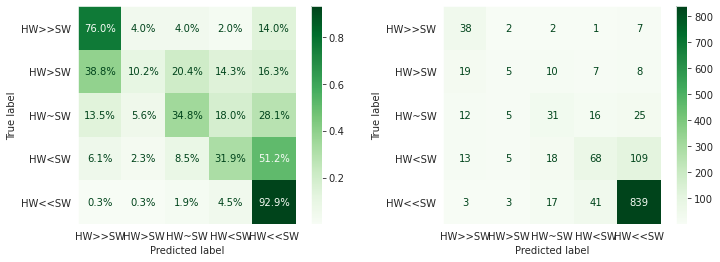

0.709132602660009

In [39]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'rf' 
TARGET_NAMES = ['HW>>SW', 'HW>SW', 'HW~SW', 'HW<SW', 'HW<<SW']
LABELS = [0, 1, 2, 3, 4]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

In [64]:
for spp in abund_cols + ['HARDWOOD_SOFTWOOD_abund']:
    obs = Y_test[spp]
    pred = spp_models[spp[:-6]]['rf'].predict(X_test)
    print(spp, round(fuzzy_accuracy(obs, pred, fuzzy_tol=0),2), round(fuzzy_accuracy(obs, pred, fuzzy_tol=1),2))

TRUE_FIR_abund 0.77 0.95
OTHER_HARDWOOD_abund 0.77 0.95
MAPLE_abund 0.9 0.98
OAK_abund 0.97 0.99
DOUGLAS_FIR_abund 0.61 0.85
SPRUCE_abund 0.92 0.97
CEDAR_abund 0.75 0.94
PONDEROSA_PINE_abund 0.9 0.96
OTHER_SOFTWOOD_abund 0.91 1.0
LODGEPOLE_PINE_abund 0.93 0.98
HEMLOCK_abund 0.67 0.9
RED_ALDER_abund 0.8 0.96
TANOAK_abund 0.97 0.99
JUNIPER_abund 0.99 1.0
LARCH_abund 0.94 0.99
HARDWOOD_SOFTWOOD_abund 0.75 0.92


In [ ]:
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.600 .. 0.602 . 0.606 . 0.611 ..
@ sample iteration 11
 0.620 ... 0.627 .. 0.627 ..
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/DOUGLAS_FIR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.67      0.76      0.86      0.71      0.81      0.65       347
    Present       0.43      0.29      0.93      0.35      0.52      0.25       205
   Abundant       0.35      0.12      0.95      0.18      0.34      0.11       234
   Dominant       0.65      0.86      0.69      0.74      0.77      0.60       518

avg / total       0.57      0.61      0.82      0.57      0.67      0.47      1304



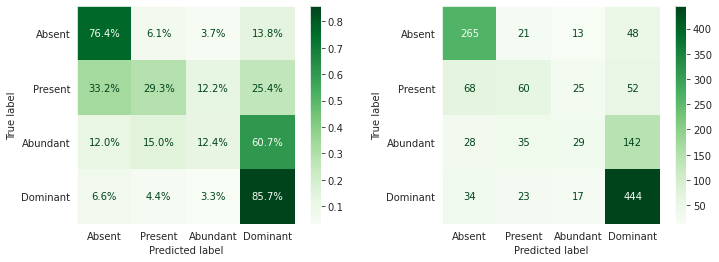

0.6547783560770574

In [40]:
SP_NAME, MOD_TYPE = 'DOUGLAS_FIR', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.578 .. 0.581 . 0.585 . 0.590 ..
@ sample iteration 11
. 0.591 .. 0.592  0.593  0.594 .. 0.598 
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/HEMLOCK_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.79      0.93      0.71      0.85      0.81      0.67       696
    Present       0.65      0.37      0.92      0.47      0.58      0.32       358
   Abundant       0.45      0.21      0.97      0.28      0.45      0.19       140
   Dominant       0.32      0.63      0.88      0.42      0.74      0.54       110

avg / total       0.67      0.67      0.81      0.65      0.70      0.51      1304



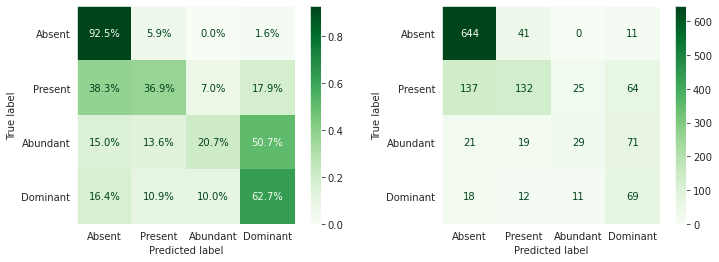

0.6660259759246479

In [41]:
SP_NAME, MOD_TYPE = 'HEMLOCK', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.627 . 0.632 .. 0.637 ....
@ sample iteration 11
..... 0.646 ... 0.648 
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/RED_ALDER_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.87      0.94      0.53      0.90      0.70      0.52      1000
    Present       0.54      0.29      0.95      0.38      0.53      0.26       217
   Abundant       0.40      0.31      0.98      0.35      0.55      0.29        45
   Dominant       0.37      0.60      0.97      0.45      0.76      0.55        42

avg / total       0.78      0.80      0.63      0.78      0.67      0.47      1304



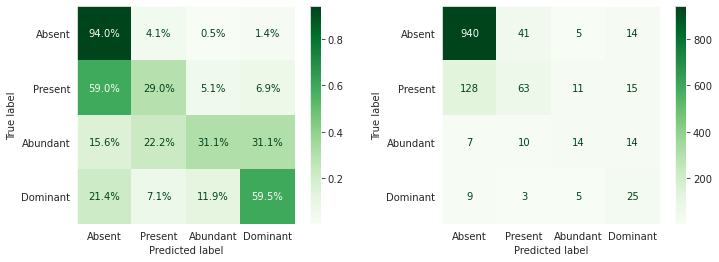

0.6128098738622956

In [42]:
SP_NAME, MOD_TYPE = 'RED_ALDER', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.225 . 0.225 ... 0.228 .. 0.231 
@ sample iteration 11
.. 0.267 .. 0.277 ... 0.277 
@ sample iteration 21
 0.279 ....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/CEDAR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.82      0.91      0.32      0.86      0.54      0.30      1010
    Present       0.46      0.26      0.94      0.33      0.49      0.22       229
   Abundant       0.11      0.10      0.97      0.10      0.31      0.09        50
   Dominant       0.07      0.07      0.99      0.07      0.26      0.06        15

avg / total       0.72      0.75      0.46      0.73      0.52      0.28      1304



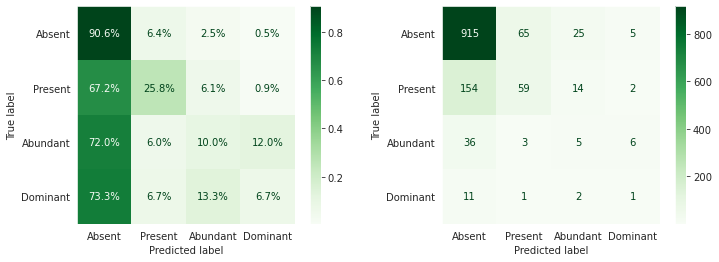

0.2438755591411016

In [43]:
SP_NAME, MOD_TYPE = 'CEDAR', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.533 . 0.533 .. 0.541 . 0.547 ..
@ sample iteration 11
.... 0.549  0.558 ....
@ sample iteration 21
 0.558 ....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/MAPLE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.97      0.93      0.70      0.95      0.81      0.67      1183
    Present       0.47      0.62      0.94      0.53      0.76      0.56       105
   Abundant       0.05      0.08      0.98      0.06      0.29      0.07        12
   Dominant       0.00      0.00      1.00      0.00      0.00      0.00         4

avg / total       0.92      0.90      0.72      0.91      0.80      0.65      1304



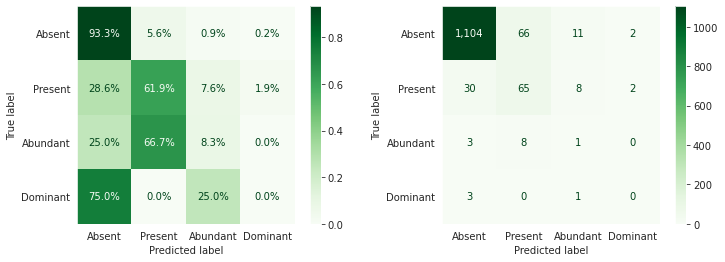

0.4535549657773432

In [44]:
SP_NAME, MOD_TYPE = 'MAPLE', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.611 .. 0.624 ... 0.627 ..
@ sample iteration 11
. 0.629 .. 0.630 . 0.631 ...
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/TRUE_FIR_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.88      0.93      0.63      0.90      0.76      0.60       978
    Present       0.41      0.30      0.92      0.35      0.53      0.26       199
   Abundant       0.31      0.19      0.97      0.24      0.44      0.17        77
   Dominant       0.31      0.52      0.95      0.39      0.70      0.47        50

avg / total       0.75      0.77      0.71      0.76      0.71      0.52      1304



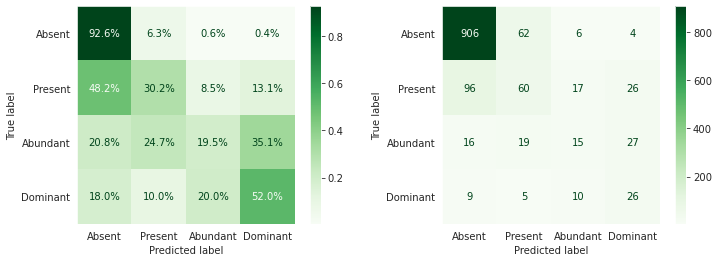

0.6633010915603033

In [45]:
SP_NAME, MOD_TYPE = 'TRUE_FIR', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.702 .... 0.712 . 0.723 ..
@ sample iteration 11
. 0.731 ...... 0.736 .
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/PONDEROSA_PINE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.97      0.97      0.82      0.97      0.89      0.81      1139
    Present       0.42      0.27      0.98      0.33      0.52      0.25        73
   Abundant       0.11      0.07      0.99      0.09      0.27      0.07        27
   Dominant       0.51      0.82      0.96      0.63      0.88      0.77        65

avg / total       0.90      0.90      0.84      0.90      0.86      0.76      1304



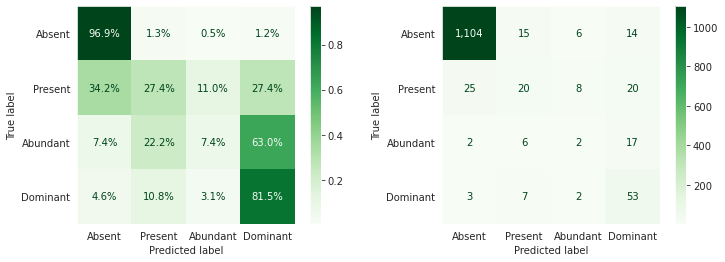

0.7749671831857206

In [46]:
SP_NAME, MOD_TYPE = 'PONDEROSA_PINE', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.527 .. 0.528 ......
@ sample iteration 11
. 0.547 ........
@ sample iteration 21
.... 0.551 Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/LODGEPOLE_PINE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.99      0.96      0.71      0.97      0.83      0.70      1241
    Present       0.31      0.43      0.96      0.36      0.65      0.40        46
   Abundant       0.00      0.00      0.99      0.00      0.00      0.00         9
   Dominant       0.27      0.50      0.99      0.35      0.70      0.47         8

avg / total       0.95      0.93      0.73      0.94      0.82      0.69      1304



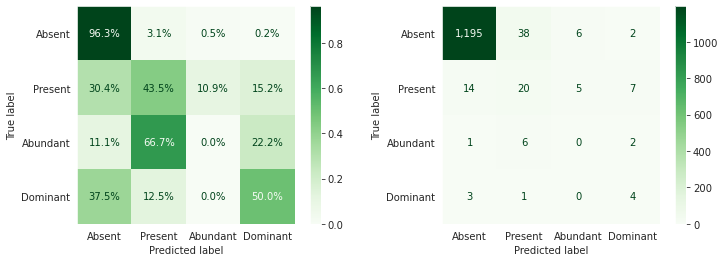

0.5528481523317734

In [47]:
SP_NAME, MOD_TYPE = 'LODGEPOLE_PINE', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.374 . 0.402 .......
@ sample iteration 11
.. 0.406 .......
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/OAK_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.98      0.98      0.42      0.98      0.65      0.44      1271
    Present       0.35      0.44      0.98      0.39      0.66      0.41        27
   Abundant       0.33      0.25      1.00      0.29      0.50      0.23         4
   Dominant       0.00      0.00      1.00      0.00      0.00      0.00         2

avg / total       0.97      0.97      0.44      0.97      0.64      0.44      1304



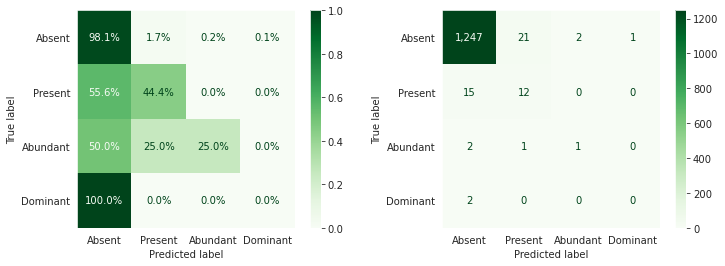

0.2938851209573704

In [48]:
SP_NAME, MOD_TYPE = 'OAK', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.866 . 0.888 .. 0.891 ....
@ sample iteration 11
 0.911 ..... 0.912 ...
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/JUNIPER_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       1.00      1.00      0.75      1.00      0.86      0.76      1296
    Present       0.00      0.00      0.99      0.00      0.00      0.00         4
   Abundant       0.00      0.00      1.00      0.00      0.00      0.00         2
   Dominant       1.00      1.00      1.00      1.00      1.00      1.00         2

avg / total       0.99      0.99      0.75      0.99      0.86      0.76      1304



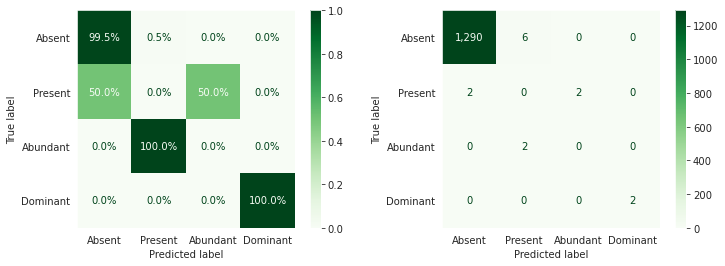

0.8113607869611341

In [49]:
SP_NAME, MOD_TYPE = 'JUNIPER', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.399  0.407 . 0.411 ......
@ sample iteration 11
..........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/SPRUCE_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.97      0.97      0.62      0.97      0.78      0.63      1216
    Present       0.44      0.29      0.98      0.35      0.54      0.27        58
   Abundant       0.18      0.32      0.98      0.23      0.56      0.29        19
   Dominant       0.24      0.45      0.99      0.31      0.67      0.42        11

avg / total       0.93      0.92      0.65      0.93      0.76      0.60      1304



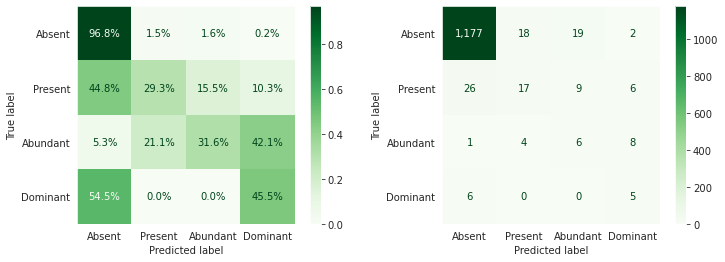

0.5722134195810669

In [50]:
SP_NAME, MOD_TYPE = 'SPRUCE', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.393  0.440 ........
@ sample iteration 11
......... 0.446 
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/TANOAK_rf_tuned.pkl



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.99      0.99      0.42      0.99      0.64      0.43      1280
    Present       0.25      0.43      0.99      0.32      0.65      0.40        14
   Abundant       0.00      0.00      1.00      0.00      0.00      0.00         4
   Dominant       0.00      0.00      1.00      0.00      0.00      0.00         6

avg / total       0.97      0.97      0.43      0.97      0.64      0.43      1304



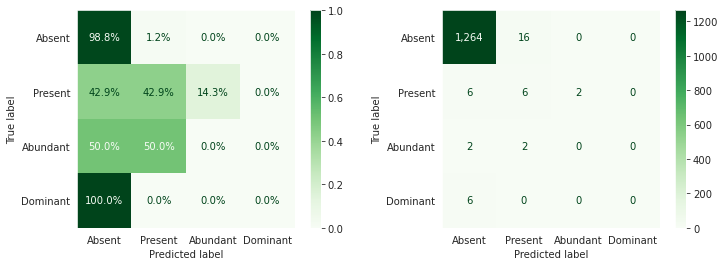

0.22997637964354734

In [51]:
SP_NAME, MOD_TYPE = 'TANOAK', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.462 .........
@ sample iteration 11
 0.467 .........
@ sample iteration 21
.....Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/LARCH_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.99      0.96      0.78      0.97      0.87      0.76      1253
    Present       0.33      0.67      0.96      0.44      0.80      0.62        36
   Abundant       0.31      0.36      0.99      0.33      0.60      0.34        11
   Dominant       0.00      0.00      0.99      0.00      0.00      0.00         4

avg / total       0.96      0.94      0.79      0.95      0.86      0.75      1304



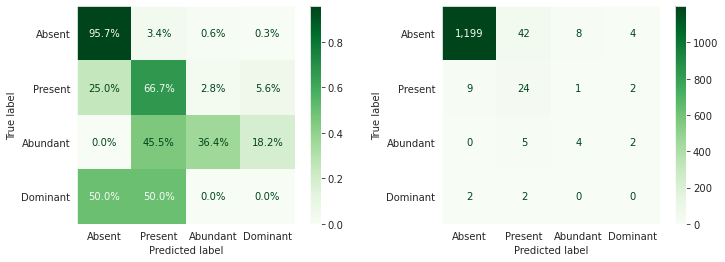

0.46296542621223125

In [52]:
SP_NAME, MOD_TYPE = 'LARCH', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.449 .........
@ sample iteration 11
........ 0.452 .
@ sample iteration 21
.. 0.456  0.459 .Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/OTHER_HARDWOOD_rf_tuned.pkl

                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.87      0.88      0.44      0.87      0.62      0.40      1061
    Present       0.31      0.30      0.89      0.30      0.51      0.25       183
   Abundant       0.30      0.21      0.99      0.25      0.45      0.19        34
   Dominant       0.19      0.31      0.97      0.24      0.55      0.28        26

avg / total       0.77      0.77      0.53      0.76      0.60      0.37      1304



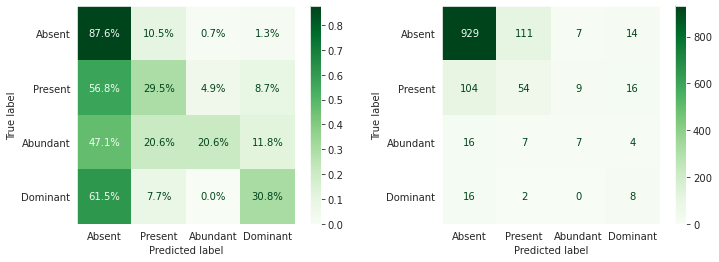

0.3456623813024108

In [53]:
SP_NAME, MOD_TYPE = 'OTHER_HARDWOOD', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)

Running 125 rounds of cross-validation.
Sampling 5 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 0.213  0.228  0.237 ...... 0.241 
@ sample iteration 11
.. 0.258 .... 0.263  0.265 .
@ sample iteration 21
... 0.271 .Done. 
Model saved at ../models/composition_ordinal_satellite/sklearn_tuned/OTHER_SOFTWOOD_rf_tuned.pkl



/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/anaconda3/envs/forest_mapping/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

     Absent       0.96      0.94      0.32      0.95      0.55      0.32      1238
    Present       0.23      0.32      0.94      0.27      0.55      0.28        66
   Abundant       0.00      0.00      1.00      0.00      0.00      0.00         0

avg / total       0.93      0.91      0.35      0.92      0.55      0.32      1304



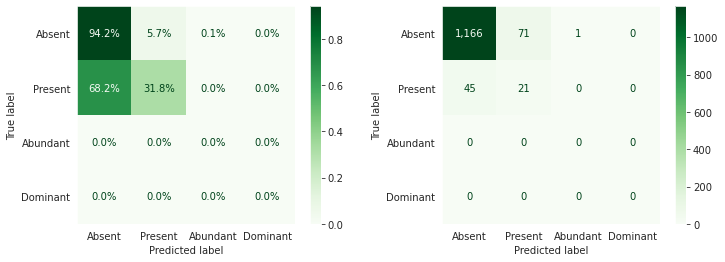

0.2130356065178033

In [54]:
SP_NAME, MOD_TYPE = 'OTHER_SOFTWOOD', 'rf' 
TARGET_NAMES = ['Absent', 'Present', 'Abundant', 'Dominant']
LABELS = [0, 1, 2, 3]
WEIGHTS = 'quadratic'

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25, labels=LABELS, weights=WEIGHTS)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                            target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
# plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])
cohen_kappa_score(Y_test[SP_NAME+'_abund'], spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                  labels=LABELS, 
                  weights=WEIGHTS)